## Phase 2.99

# Regression Review

> *Predicting `list_price` using X-features.*

In [1]:
import os
import warnings

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import OneHotEncoder, StandardScaler

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load Data

In [3]:
df = pd.read_csv('data/review_dataset.csv', index_col=0)
df.head()

,prod_id,ages,piece_count,set_name,prod_desc,prod_long_desc,theme_name,country,list_price,num_reviews,play_star_rating,review_difficulty,star_rating,val_star_rating
0,75823,6-12,277,Bird Island Egg Heist,Catapult into action and take back the eggs fr...,Use the staircase catapult to launch Red into ...,Angry Birds™,US,$29.99,2.0,4.0,Average,4.5,4.0
1,75822,6-12,168,Piggy Plane Attack,Launch a flying attack and rescue the eggs fro...,Pilot Pig has taken off from Bird Island with ...,Angry Birds™,US,$19.99,2.0,4.0,Easy,5.0,4.0
2,75821,6-12,74,Piggy Car Escape,Chase the piggy with lightning-fast Chuck and ...,Pitch speedy bird Chuck against the Piggy Car....,Angry Birds™,US,$12.99,11.0,4.3,Easy,4.3,4.1
3,21030,12+,1032,United States Capitol Building,Explore the architecture of the United States ...,Discover the architectural secrets of the icon...,Architecture,US,$99.99,23.0,3.6,Average,4.6,4.3
4,21035,12+,744,Solomon R. Guggenheim Museum®,Recreate the Solomon R. Guggenheim Museum® wit...,Discover the architectural secrets of Frank Ll...,Architecture,US,$79.99,14.0,3.2,Challenging,4.6,4.1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10870 entries, 0 to 10869
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   prod_id            10870 non-null  int64  
 1   ages               10870 non-null  object 
 2   piece_count        10870 non-null  int64  
 3   set_name           10870 non-null  object 
 4   prod_desc          10512 non-null  object 
 5   prod_long_desc     10870 non-null  object 
 6   theme_name         10870 non-null  object 
 7   country            10870 non-null  object 
 8   list_price         10870 non-null  object 
 9   num_reviews        9449 non-null   float64
 10  play_star_rating   9321 non-null   float64
 11  review_difficulty  9104 non-null   object 
 12  star_rating        9449 non-null   float64
 13  val_star_rating    9301 non-null   float64
dtypes: float64(4), int64(2), object(8)
memory usage: 1.2+ MB


## Preliminary Cleaning

In [5]:
df.isna().sum()

prod_id                 0
ages                    0
piece_count             0
set_name                0
prod_desc             358
prod_long_desc          0
theme_name              0
country                 0
list_price              0
num_reviews          1421
play_star_rating     1549
review_difficulty    1766
star_rating          1421
val_star_rating      1569
dtype: int64

In [6]:
if 'prod_desc' in df.columns:
    df.drop('prod_desc', axis=1, inplace=True)
    df.drop('prod_long_desc', axis=1, inplace=True)
df.head()

,prod_id,ages,piece_count,set_name,theme_name,country,list_price,num_reviews,play_star_rating,review_difficulty,star_rating,val_star_rating
0,75823,6-12,277,Bird Island Egg Heist,Angry Birds™,US,$29.99,2.0,4.0,Average,4.5,4.0
1,75822,6-12,168,Piggy Plane Attack,Angry Birds™,US,$19.99,2.0,4.0,Easy,5.0,4.0
2,75821,6-12,74,Piggy Car Escape,Angry Birds™,US,$12.99,11.0,4.3,Easy,4.3,4.1
3,21030,12+,1032,United States Capitol Building,Architecture,US,$99.99,23.0,3.6,Average,4.6,4.3
4,21035,12+,744,Solomon R. Guggenheim Museum®,Architecture,US,$79.99,14.0,3.2,Challenging,4.6,4.1


In [7]:
if 'set_name' in df.columns:
    df.drop('set_name', axis=1, inplace=True)

In [8]:
if 'prod_id' in df.columns:
    df.drop('prod_id', axis=1, inplace=True)

In [9]:
def fill_with_median(column_name, dataframe):
    """DOCSTRING"""
    
    dataframe[column_name] = (
        dataframe[column_name]
        .fillna(dataframe[column_name].median())
    )
    return dataframe

In [10]:
df = fill_with_median('num_reviews', df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10870 entries, 0 to 10869
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ages               10870 non-null  object 
 1   piece_count        10870 non-null  int64  
 2   theme_name         10870 non-null  object 
 3   country            10870 non-null  object 
 4   list_price         10870 non-null  object 
 5   num_reviews        10870 non-null  float64
 6   play_star_rating   9321 non-null   float64
 7   review_difficulty  9104 non-null   object 
 8   star_rating        9449 non-null   float64
 9   val_star_rating    9301 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 934.1+ KB


In [11]:
df[['star_rating', 'play_star_rating']].corr()

,star_rating,play_star_rating
star_rating,1.000000,0.619246
play_star_rating,0.619246,1.000000


In [12]:
df = fill_with_median('play_star_rating', df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10870 entries, 0 to 10869
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ages               10870 non-null  object 
 1   piece_count        10870 non-null  int64  
 2   theme_name         10870 non-null  object 
 3   country            10870 non-null  object 
 4   list_price         10870 non-null  object 
 5   num_reviews        10870 non-null  float64
 6   play_star_rating   10870 non-null  float64
 7   review_difficulty  9104 non-null   object 
 8   star_rating        9449 non-null   float64
 9   val_star_rating    9301 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 934.1+ KB


In [13]:
df['review_difficulty'].fillna('Missing', inplace=True)
df['review_difficulty'].value_counts()

Easy                3826
Average             3357
Missing             1766
Challenging          995
Very Easy            905
Very Challenging      21
Name: review_difficulty, dtype: int64

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10870 entries, 0 to 10869
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ages               10870 non-null  object 
 1   piece_count        10870 non-null  int64  
 2   theme_name         10870 non-null  object 
 3   country            10870 non-null  object 
 4   list_price         10870 non-null  object 
 5   num_reviews        10870 non-null  float64
 6   play_star_rating   10870 non-null  float64
 7   review_difficulty  10870 non-null  object 
 8   star_rating        9449 non-null   float64
 9   val_star_rating    9301 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 934.1+ KB


<AxesSubplot:>

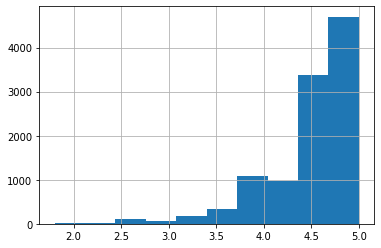

In [15]:
df = fill_with_median('star_rating', df)
df['star_rating'].hist()

In [16]:
df = fill_with_median('val_star_rating', df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10870 entries, 0 to 10869
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ages               10870 non-null  object 
 1   piece_count        10870 non-null  int64  
 2   theme_name         10870 non-null  object 
 3   country            10870 non-null  object 
 4   list_price         10870 non-null  object 
 5   num_reviews        10870 non-null  float64
 6   play_star_rating   10870 non-null  float64
 7   review_difficulty  10870 non-null  object 
 8   star_rating        10870 non-null  float64
 9   val_star_rating    10870 non-null  float64
dtypes: float64(4), int64(1), object(5)
memory usage: 934.1+ KB


In [17]:
df.isna().sum()

ages                 0
piece_count          0
theme_name           0
country              0
list_price           0
num_reviews          0
play_star_rating     0
review_difficulty    0
star_rating          0
val_star_rating      0
dtype: int64

## Split out Target

In [18]:
TARGET = 'list_price'
X_VALS = [c for c in df.columns if c != TARGET]
TARGET in X_VALS

False

In [19]:
X_VALS

['ages',
 'piece_count',
 'theme_name',
 'country',
 'num_reviews',
 'play_star_rating',
 'review_difficulty',
 'star_rating',
 'val_star_rating']

## Cleaning!

In [20]:
# Cleaning target from string to float.
df[TARGET] = df[TARGET].apply(lambda x: round(float(x.replace('$', '')), 2))
df[TARGET]

0        29.99
1        19.99
2        12.99
3        99.99
4        79.99
         ...  
10865    42.69
10866    30.49
10867    30.49
10868    18.29
10869    18.29
Name: list_price, Length: 10870, dtype: float64

In [21]:
# Check the columns and their value counts.
for column in X_VALS:
    print('#'*10, column.title(), '#'*10)
    print(df[column].value_counts())
    print('\n\n')

########## Ages ##########
6-12     1476
7-14     1219
8-14     1055
5-12      891
2-5       777
7-12      711
4-7       583
10+       534
9-14      477
16+       399
8-12      348
4-99      311
12+       298
8+        226
1½-3      213
6-14      192
14+       191
10-21     184
6+        148
10-16     148
1½-5      113
9-16       92
11-16      66
5+         46
9-12       44
12-16      42
5-8        21
9+         21
10-14      21
4+         21
7+          2
Name: ages, dtype: int64



########## Piece_Count ##########
1      337
109     86
69      85
24      84
149     84
      ... 
193      2
754      2
412      2
206      2
252      2
Name: piece_count, Length: 445, dtype: int64



########## Theme_Name ##########
Star Wars™                               1377
DUPLO®                                   1103
City                                     1072
Friends                                   607
Juniors                                   604
Technic                                   505

<AxesSubplot:>

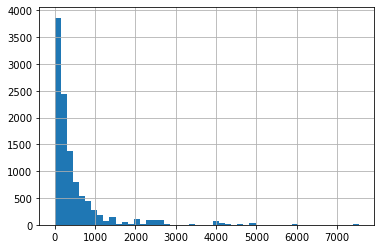

In [22]:
# Impute values that are 1 to be the median.
piece_count_median = df.loc[df['piece_count'] != 1, 'piece_count'].median()
df.loc[df['piece_count'] == 1, 'piece_count'] = piece_count_median
df['piece_count'].hist(bins=50)

<AxesSubplot:>

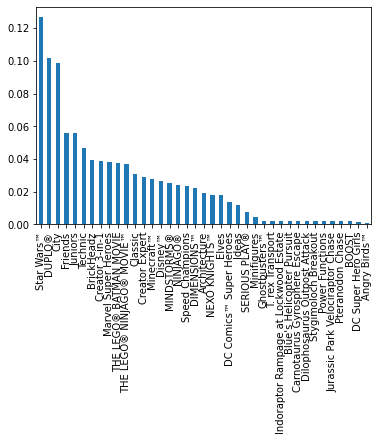

In [23]:
df['theme_name'].value_counts(normalize=True).plot(kind='bar')

In [24]:
# Grabbing the most common themes.
themes_to_keep = []
for theme_name in df['theme_name'].value_counts(normalize=True).index:
    percent = df['theme_name'].value_counts(normalize=True)[theme_name]
    if percent > 0.08:
        themes_to_keep.append(theme_name)

themes_to_keep

['Star Wars™', 'DUPLO®', 'City']

In [25]:
new_themes = []
for theme in df['theme_name']:
    if theme in themes_to_keep:
        new_themes.append(theme)
    else:
        new_themes.append('Other')
df['theme_name'] = new_themes
df['theme_name']= (
    df['theme_name']
    .apply(lambda x: x.replace('™', '').replace('®', ''))
)
df['theme_name'].value_counts()

Other        7318
Star Wars    1377
DUPLO        1103
City         1072
Name: theme_name, dtype: int64

### AGES

In [26]:
# 1.5+, 4+, 6+, 9+, 13+, 18+

In [27]:
df['ages'] = df['ages'].apply(lambda x: x.replace('½', '.5'))
df['ages'].value_counts()

6-12     1476
7-14     1219
8-14     1055
5-12      891
2-5       777
7-12      711
4-7       583
10+       534
9-14      477
16+       399
8-12      348
4-99      311
12+       298
8+        226
1.5-3     213
6-14      192
14+       191
10-21     184
10-16     148
6+        148
1.5-5     113
9-16       92
11-16      66
5+         46
9-12       44
12-16      42
5-8        21
10-14      21
9+         21
4+         21
7+          2
Name: ages, dtype: int64

In [28]:
def convert_age_range_to_min_age(age_value):
    """DOCSTRING"""
    
    if '+' in age_value:
        return float(age_value.replace('+', ''))
    return float(age_value.split('-')[0])

df['min_age'] = df['ages'].apply(convert_age_range_to_min_age)
df.head()

,ages,piece_count,theme_name,country,list_price,num_reviews,play_star_rating,review_difficulty,star_rating,val_star_rating,min_age
0,6-12,277.0,Other,US,29.99,2.0,4.0,Average,4.5,4.0,6.0
1,6-12,168.0,Other,US,19.99,2.0,4.0,Easy,5.0,4.0,6.0
2,6-12,74.0,Other,US,12.99,11.0,4.3,Easy,4.3,4.1,6.0
3,12+,1032.0,Other,US,99.99,23.0,3.6,Average,4.6,4.3,12.0
4,12+,744.0,Other,US,79.99,14.0,3.2,Challenging,4.6,4.1,12.0


## EDA

<AxesSubplot:xlabel='piece_count'>

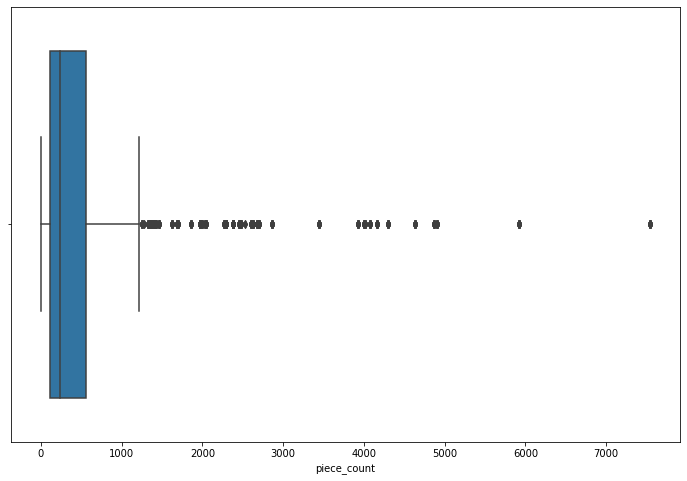

In [29]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(x='piece_count', data=df, ax=ax)

In [30]:
# Removing outliers.
df = df.loc[df['piece_count'] < 2300]
df

,ages,piece_count,theme_name,country,list_price,num_reviews,play_star_rating,review_difficulty,star_rating,val_star_rating,min_age
0,6-12,277.0,Other,US,29.99,2.0,4.0,Average,4.5,4.0,6.0
1,6-12,168.0,Other,US,19.99,2.0,4.0,Easy,5.0,4.0,6.0
2,6-12,74.0,Other,US,12.99,11.0,4.3,Easy,4.3,4.1,6.0
3,12+,1032.0,Other,US,99.99,23.0,3.6,Average,4.6,4.3,12.0
4,12+,744.0,Other,US,79.99,14.0,3.2,Challenging,4.6,4.1,12.0
...,...,...,...,...,...,...,...,...,...,...,...
10865,7-14,254.0,Other,PT,42.69,18.0,4.2,Easy,4.2,4.4,7.0
10866,7-14,204.0,Other,PT,30.49,8.0,4.1,Average,4.4,4.1,7.0
10867,7-14,201.0,Other,PT,30.49,19.0,4.1,Easy,4.6,4.4,7.0
10868,6-12,141.0,Other,PT,18.29,7.0,4.0,Easy,4.1,4.4,6.0


<AxesSubplot:xlabel='piece_count'>

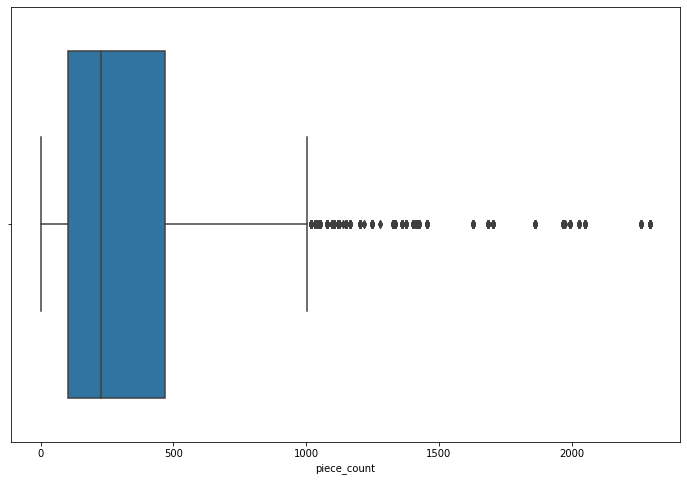

In [31]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(x='piece_count', data=df, ax=ax)

<BarContainer object of 4 artists>

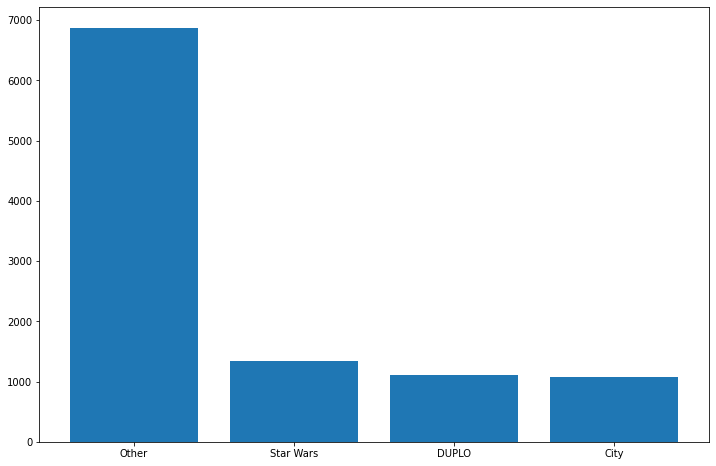

In [32]:
fig, ax = plt.subplots(figsize=(12,8))
ax.bar(x=df['theme_name'].value_counts().index, 
       height=df['theme_name'].value_counts(),
       color='tab:blue')

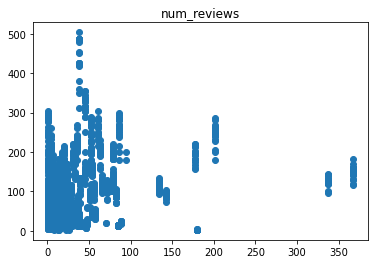

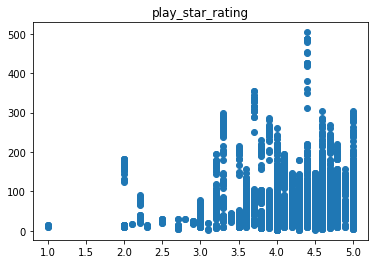

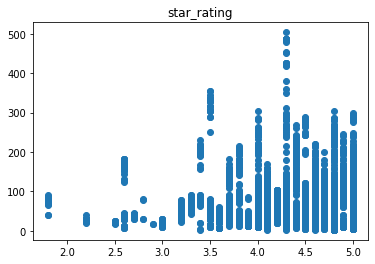

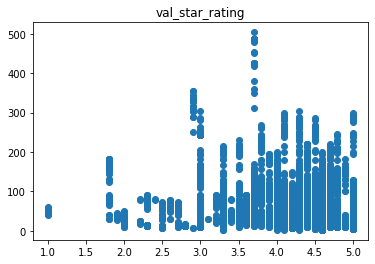

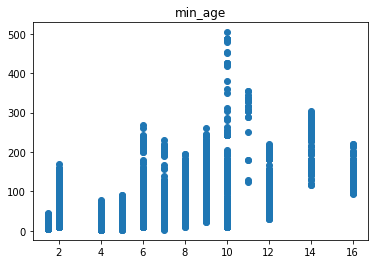

In [33]:
for col in ['num_reviews', 'play_star_rating',
            'star_rating', 'val_star_rating', 'min_age']:
    plt.scatter(df[col], df[TARGET])
    plt.title(col)
    plt.show()

## Train-Test-Split

In [34]:
y = df[TARGET]
X = df.drop(columns=[TARGET, 'ages'])
X

,piece_count,theme_name,country,num_reviews,play_star_rating,review_difficulty,star_rating,val_star_rating,min_age
0,277.0,Other,US,2.0,4.0,Average,4.5,4.0,6.0
1,168.0,Other,US,2.0,4.0,Easy,5.0,4.0,6.0
2,74.0,Other,US,11.0,4.3,Easy,4.3,4.1,6.0
3,1032.0,Other,US,23.0,3.6,Average,4.6,4.3,12.0
4,744.0,Other,US,14.0,3.2,Challenging,4.6,4.1,12.0
...,...,...,...,...,...,...,...,...,...
10865,254.0,Other,PT,18.0,4.2,Easy,4.2,4.4,7.0
10866,204.0,Other,PT,8.0,4.1,Average,4.4,4.1,7.0
10867,201.0,Other,PT,19.0,4.1,Easy,4.6,4.4,7.0
10868,141.0,Other,PT,7.0,4.0,Easy,4.1,4.4,6.0


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2021)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7789, 9), (2597, 9), (7789,), (2597,))

In [36]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

## Data Processing / Feature Engineering

In [37]:
# Create min_age**2
X_train['min_age_squared'] = X_train['min_age'] ** 2
X_test['min_age_squared'] = X_test['min_age'] ** 2
X_train

/Users/claudefried/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/claudefried/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,piece_count,theme_name,country,num_reviews,play_star_rating,review_difficulty,star_rating,val_star_rating,min_age,min_age_squared
0,234.0,Other,IE,3.0,5.0,Average,5.0,3.3,10.0,100.0
1,452.0,Star Wars,IT,11.0,4.2,Challenging,4.5,4.4,10.0,100.0
2,1363.0,Other,FI,52.0,3.2,Average,3.8,4.0,14.0,196.0
3,470.0,Other,DE,1.0,5.0,Average,5.0,5.0,8.0,64.0
4,2262.0,Other,DE,177.0,4.4,Challenging,4.6,4.4,16.0,256.0
...,...,...,...,...,...,...,...,...,...,...
7784,104.0,Other,DE,1.0,5.0,Average,5.0,5.0,5.0,25.0
7785,48.0,Other,CA,1.0,5.0,Very Easy,5.0,5.0,6.0,36.0
7786,1098.0,Other,AU,12.0,4.0,Average,4.8,4.6,10.0,100.0
7787,347.0,City,GB,2.0,4.5,Very Easy,5.0,5.0,5.0,25.0


In [38]:
NUM_COLS = X_train.select_dtypes('number').columns
CAT_COLS = X_train.select_dtypes('object').columns
CAT_COLS

Index(['theme_name', 'country', 'review_difficulty'], dtype='object')

In [39]:
# OHE
ohe = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = ohe.fit_transform(X_train[CAT_COLS])
X_test_ohe = ohe.transform(X_test[CAT_COLS])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names(CAT_COLS))
X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe.get_feature_names(CAT_COLS))

X_train_ohe.columns = [c.lower() for c in X_train_ohe]
X_test_ohe.columns = [c.lower() for c in X_test_ohe]

In [40]:
X_train_ohe.head()

,theme_name_duplo,theme_name_other,theme_name_star wars,country_au,country_be,country_ca,country_ch,country_cz,country_de,country_dn,...,country_no,country_nz,country_pl,country_pt,country_us,review_difficulty_challenging,review_difficulty_easy,review_difficulty_missing,review_difficulty_very challenging,review_difficulty_very easy
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [41]:
X_train_raw = pd.concat([X_train[NUM_COLS], 
                         X_train_ohe], 
                        axis=1)
X_test_raw = pd.concat([X_test[NUM_COLS], 
                        X_test_ohe], 
                       axis=1)

In [42]:
# Scaling data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[NUM_COLS])
X_test_scaled = scaler.transform(X_test[NUM_COLS])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train[NUM_COLS].columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test[NUM_COLS].columns)

In [43]:
X_train_scaled.shape, X_test_scaled.shape

((7789, 7), (2597, 7))

In [44]:
X_train_scaled = pd.concat([X_train_scaled, 
                            X_train_ohe], 
                           axis=1)
X_test_scaled = pd.concat([X_test_scaled, 
                           X_test_ohe], 
                          axis=1)

In [45]:
X_train_raw

,piece_count,num_reviews,play_star_rating,star_rating,val_star_rating,min_age,min_age_squared,theme_name_duplo,theme_name_other,theme_name_star wars,...,country_no,country_nz,country_pl,country_pt,country_us,review_difficulty_challenging,review_difficulty_easy,review_difficulty_missing,review_difficulty_very challenging,review_difficulty_very easy
0,234.0,3.0,5.0,5.0,3.3,10.0,100.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,452.0,11.0,4.2,4.5,4.4,10.0,100.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1363.0,52.0,3.2,3.8,4.0,14.0,196.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,470.0,1.0,5.0,5.0,5.0,8.0,64.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2262.0,177.0,4.4,4.6,4.4,16.0,256.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7784,104.0,1.0,5.0,5.0,5.0,5.0,25.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7785,48.0,1.0,5.0,5.0,5.0,6.0,36.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7786,1098.0,12.0,4.0,4.8,4.6,10.0,100.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7787,347.0,2.0,4.5,5.0,5.0,5.0,25.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [46]:
X_train_scaled

,piece_count,num_reviews,play_star_rating,star_rating,val_star_rating,min_age,min_age_squared,theme_name_duplo,theme_name_other,theme_name_star wars,...,country_no,country_nz,country_pl,country_pt,country_us,review_difficulty_challenging,review_difficulty_easy,review_difficulty_missing,review_difficulty_very challenging,review_difficulty_very easy
0,-0.325569,-0.336782,1.072442,0.993205,-1.459574,1.202087,1.142538,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.220617,-0.071377,-0.305584,-0.030248,0.287734,1.202087,1.142538,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2.503076,1.288824,-2.028118,-1.463081,-0.347651,2.659486,3.448402,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.265715,-0.403134,1.072442,0.993205,1.240811,0.473388,0.277839,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.755469,5.435777,0.038922,0.174443,0.287734,3.388185,4.889566,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7784,-0.651277,-0.403134,1.072442,0.993205,1.240811,-0.619661,-0.658918,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7785,-0.791582,-0.403134,1.072442,0.993205,1.240811,-0.255311,-0.394704,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7786,1.839133,-0.038202,-0.650091,0.583824,0.605426,1.202087,1.142538,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7787,-0.042454,-0.369958,0.211176,0.993205,1.240811,-0.619661,-0.658918,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Modeling (in StatsModels / Sklearn)
**Linear Model Assumptions**
1. *Residual Normality*
    - `sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)`
    - *Omnibus Value*
    
    
2. *Homoskedasticity*
    - *Durbin-Watson*
    
    
3. *Multicollinearity*
    - *VIF* (`variance_inflation_factor()`)

#### Helper functions.

In [47]:
def create_vif_dct(dataframe, const_col_name='const'):
    """DOCSTRING"""
    
    if const_col_name not in dataframe.columns:
        dataframe = sm.add_constant(dataframe)
        
    # Dummy-checking.
    df = dataframe.select_dtypes('number')
    if df.shape != dataframe.shape:
        warnings.warn('\n\nThere are non-numerical columns trying to be passed!\nThese have automatically been removed.\n')
    if df.isna().sum().any():
        raise ValueError('There may not be any missing values in the dataframe!')
        
    # Creating VIF Dictionary.
    vif_dct = {}

    # Loop through each row and set the variable name to the VIF. 
    for i in range(len(df.columns)):
        vif = variance_inflation_factor(df.values, i)
        v = df.columns[i]
        vif_dct[v] = vif

    return vif_dct

### Baseline Model

In [48]:
model = sm.OLS(y_train, X_train_scaled).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             list_price   R-squared (uncentered):                   0.861
Model:                            OLS   Adj. R-squared (uncentered):              0.860
Method:                 Least Squares   F-statistic:                              1368.
Date:                Thu, 30 Sep 2021   Prob (F-statistic):                        0.00
Time:                        20:08:02   Log-Likelihood:                         -36860.
No. Observations:                7789   AIC:                                  7.379e+04
Df Residuals:                    7754   BIC:                                  7.403e+04
Df Model:                          35                                                  
Covariance Type:            nonrobust                                                  
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
piece_count                           42.9354      0.492     87.189      0.000      41.970      43.901
num_reviews                           -2.0118      0.429     -4.688      0.000      -2.853      -1.170
play_star_rating                       5.3279      0.437     12.185      0.000       4.471       6.185
star_rating                           -0.5156      0.529     -0.975      0.330      -1.553       0.521
val_star_rating                       -8.3213      0.459    -18.141      0.000      -9.221      -7.422
min_age                               20.1812      2.113      9.552      0.000      16.039      24.323
min_age_squared                      -16.8489      1.926     -8.746      0.000     -20.625     -13.073
theme_name_duplo                      50.8451      2.038     24.947      0.000      46.850      54.840
theme_name_other                       9.6670      0.955     10.120      0.000       7.794      11.540
theme_name_star wars                  16.3475      1.302     12.556      0.000      13.795      18.900
country_au                            34.2977      1.659     20.670      0.000      31.045      37.550
country_be                            39.4121      1.678     23.487      0.000      36.123      42.701
country_ca                            26.1140      1.472     17.746      0.000      23.229      28.999
country_ch                            36.1076      1.718     21.014      0.000      32.739      39.476
country_cz                            40.7889      1.711     23.837      0.000      37.435      44.143
country_de                            39.7126      1.714     23.169      0.000      36.353      43.073
country_dn                            28.4310      1.702     16.704      0.000      25.095      31.767
country_es                            38.6077      1.716     22.504      0.000      35.245      41.971
country_fi                            45.0951      1.695     26.597      0.000      41.772      48.419
country_fr                            36.8344      1.674     22.004      0.000      33.553      40.116
country_gb                            37.0129      1.684     21.973      0.000      33.711      40.315
country_ie                            34.1705      1.698     20.121      0.000      30.841      37.500
country_it                            35.1130      1.738     20.201      0.000      31.706      38.520
country_lu                            40.1607      1.705     23.550      0.000      36.818      43.504
country_nl                            40.4290      1.683     24.023      0.000      37.130      43.728
country_no                            45.0116      1.743     25.817      0.000      41.594      48.4

In [49]:
for df in [X_train_scaled, X_train_raw, X_test_scaled, X_test_raw]:
    if 'star_rating' in df.columns:
        df.drop('star_rating', axis=1, inplace=True)

In [50]:
X_train_raw.columns

Index(['piece_count', 'num_reviews', 'play_star_rating', 'val_star_rating',
       'min_age', 'min_age_squared', 'theme_name_duplo', 'theme_name_other',
       'theme_name_star wars', 'country_au', 'country_be', 'country_ca',
       'country_ch', 'country_cz', 'country_de', 'country_dn', 'country_es',
       'country_fi', 'country_fr', 'country_gb', 'country_ie', 'country_it',
       'country_lu', 'country_nl', 'country_no', 'country_nz', 'country_pl',
       'country_pt', 'country_us', 'review_difficulty_challenging',
       'review_difficulty_easy', 'review_difficulty_missing',
       'review_difficulty_very challenging', 'review_difficulty_very easy'],
      dtype='object')

### Modeling Continued...

In [51]:
model = sm.OLS(y_train, X_train_scaled).fit()

# https://stackoverflow.com/a/52976810
results_as_html = model.summary().tables[1].as_html()
results = pd.read_html(results_as_html, header=0, index_col=0)[0]
results.sort_values('coef', ascending=False)

,coef,std err,t,P>|t|,[0.025,0.975]
theme_name_duplo,50.7307,2.035,24.933,0.000,46.742,54.719
review_difficulty_very challenging,45.9185,7.155,6.418,0.000,31.893,59.944
country_fi,45.0928,1.695,26.596,0.000,41.769,48.416
country_no,45.0045,1.743,25.813,0.000,41.587,48.422
piece_count,42.9596,0.492,87.349,0.000,41.995,43.924
country_cz,40.7831,1.711,23.834,0.000,37.429,44.137
country_nz,40.5259,1.675,24.195,0.000,37.242,43.809
country_nl,40.4279,1.683,24.023,0.000,37.129,43.727
country_lu,40.1451,1.705,23.542,0.000,36.802,43.488
country_pl,39.9462,1.702,23.468,0.000,36.609,43.283


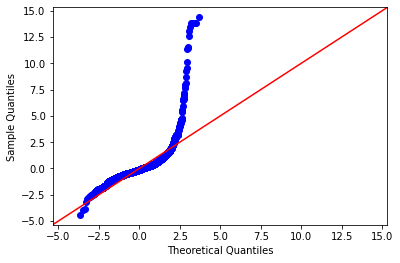

In [52]:
sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True);

In [53]:
create_vif_dct(X_train_scaled)

{'const': 33.29317665664635,
 'piece_count': 2.553386252725949,
 'num_reviews': 1.8740512526905402,
 'play_star_rating': 1.478928845877676,
 'val_star_rating': 1.385942567388923,
 'min_age': 45.928349185047544,
 'min_age_squared': 38.26534520218798,
 'theme_name_duplo': 4.382182991517621,
 'theme_name_other': 2.8459574369841123,
 'theme_name_star wars': 2.26708352439617,
 'country_au': 1.9201823130135642,
 'country_be': 1.896591146104135,
 'country_ca': 2.2832119807214877,
 'country_ch': 1.8524428197183225,
 'country_cz': 1.849653494295948,
 'country_de': 1.8503781145844125,
 'country_dn': 1.8663779688739497,
 'country_es': 1.8496788186835145,
 'country_fi': 1.8732050229427568,
 'country_fr': 1.9079717885157312,
 'country_gb': 1.8920281162375483,
 'country_ie': 1.8713360859566976,
 'country_it': 1.821810473081679,
 'country_lu': 1.8503994750076402,
 'country_nl': 1.891958092899932,
 'country_no': 1.815127603635848,
 'country_nz': 1.8943571282680782,
 'country_pl': 1.8672605154762176,
 